In [1]:
# Ref: mAP https://github.com/rafaelpadilla/Object-Detection-Metrics

In [1]:
from skimage.measure import label
#! pip install mat73
import scipy.io
import cv2
import glob, os, re, random
from PIL import Image
import numpy as np
import os,cv2, re
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import csv, cv2

from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from pygsp import graphs
import itertools

G1 = graphs.Grid2d(128, 128)  # make sure x[0] having dimension nVertices x nChannel
G1.plotting['vertex_size'] = 20

In [2]:
# Load this file to display ground truth Label
with open("./tmp/dataset/IMG_LBL_MSK_DEL_NHOP_GRF_CLS.pkl","rb") as fp:
    display_label = pickle.load(fp)

def iou_score(a, b):
    a = set(a)
    b = set(b)
    intersection = a.intersection(b)
    union = a.union(b)
    iou_score_ = len(intersection)/len(union)
    return iou_score_
    
def dataframe(start_img, end_img):
    with open("./tmp/dataset/ALL_param_Delta_nhop_Anc_mask_iou.pkl","rb") as fp:
        ALL_param_list = pickle.load(fp)

    images = [i for i in range(len(ALL_param_list))]
    column_names = ["Delta", "N-hop", "GT_bbox", "IOU"]
    d = {}
    for name in range(start_img, end_img,1):
        d[name] = pd.DataFrame(columns = column_names)
        for i in range(128*128):   
            d[name].loc[i] = ALL_param_list[name][i]

    ## sort in place
    for name, df in d.items():
        df.sort_values(by='IOU', ascending=False, inplace = True)
    return d

def AP_score(ALL_GT_list, ALL_pred_list, start_img, end_img):
    ###### CREATE DATAFRAME for storing pred bbox will used for calculating mAP ######
    column_names = ["Images", "Detections", "Confidences", "TP_FP", "IOU"]
    df_mAP = pd.DataFrame(columns = column_names)
    count = 0
    for i in range(start_img,end_img,1):    
        filename = str(i)+".jpg"
        for row_p in ALL_pred_list[i-start_img]:
            # Add rows to the mAP dataframe
            conf = row_p[1]
            df_mAP.loc[count] = np.array([str(filename), count+1, conf, 'FP', 0])

            ## calculate iou between list of gt bbox and pred box
            thr = 0
            for k in ALL_GT_list[i-start_img]:
                iou = iou_score(k[2],row_p[0])
                #print("iou",iou)
                if iou >0.5:
                    df_mAP.loc[count]['TP_FP'] = 'TP'
                if iou > thr:
                    thr = iou
                    df_mAP.loc[count]['IOU'] = iou

            count = count+1
    return df_mAP
  
def display(ALL_GT_list, ALL_pred_list, start_img, end_img):
    for im_num in range(start_img, end_img, 1):
        pred_sig = np.reshape(display_label[0][im_num].astype(np.float32), [-1, 128 * 128, 3])
        sign = np.reshape(pred_sig[0], (128, 128, 3))
        sign = sign.astype(np.uint8)
        plt.subplot(121),plt.imshow(sign)
        plt.subplot(122),plt.imshow(display_label[1][im_num])

        img_gray = np.reshape(rgb2gray(sign), [-1])

        ############## plot the object #############
        ax = plt.figure(figsize=[5, 5])
        G1.plot_signal(img_gray, ax=plt.gca())

        ###### Code plotting the GT bbox on the graph 
        for G in ALL_GT_list[im_num-start_img]:
            bbox = G[2]

            b_coord = np.array(bbox)
            poly_coord = G1.coords[b_coord]
            hull = ConvexHull(poly_coord, qhull_options='QJ')

            for simplex in hull.simplices:
                plt.plot(poly_coord[simplex, 0], poly_coord[simplex, 1], 'r-')

        ###### Code plotting the pred bbox on the graph 
        for P in ALL_pred_list[im_num-start_img]:
            bbox = P[0]

            b_coord = np.array(bbox)
            poly_coord = G1.coords[b_coord]
            hull = ConvexHull(poly_coord, qhull_options='QJ')

            for simplex in hull.simplices:
                plt.plot(poly_coord[simplex, 0], poly_coord[simplex, 1], 'w-')

        plt.show()
        print("Finish plotting bbox")
    
def all_pred_box(start_img, end_img):
    ALL_pred_list = []
    for im_num in range(start_img,end_img,1):
        pred_sig = np.reshape(display_label[0][im_num].astype(np.float32), [-1, 128 * 128, 3])
        pred_sig = pred_sig.astype(np.float32)

        file = "./tmp/bbox/img"+str(im_num)+"_bbox.pkl"
        with open(file,"rb") as fp:
            object_pred = pickle.load(fp)

        sign = np.reshape(pred_sig[0], (128, 128, 3))
        sign = sign.astype(np.uint8)

        img_gray = np.reshape(rgb2gray(sign), [-1])

        prediction = []
        for j in range(0,2):
            D = object_pred[j]
            data_arr = np.array(object_pred[j])
            L = [list(v) for k,v in itertools.groupby(data_arr, lambda x: x[0])]

            B = []
            for i in range(len(L)):
                B.append(L[i][-1])
            B = np.array(B)

            D = []
            Threshold = 0.01
            while len(B)!= 0:
                #index of the max score
                m = np.argmax([v.numpy() for v in B[:,-1]])
                # find actual bbox
                M = B[m]
                D.append(M)
                B = np.delete(B, m, axis=0)

                for obj in range((len(B)-1), -1, -1):
                    if iou_score(M[2], B[obj][2]) >= Threshold:
                        B = np.delete(B, obj, axis=0)

            prediction.append(D)

        ## collect both classes bbox into one list
        pred_list = []
        for i in range(0, len(prediction)):
            for j in prediction[i]:
                bbox = j[2]
                conf = j[-1]
                bbox_conf = [bbox,conf.numpy()]
                pred_list.append(bbox_conf)

        ALL_pred_list.append(pred_list)
    return ALL_pred_list

def all_gt_box(start_img, end_img, d):
    ALL_GT_list = []
    for im_num in range(start_img,end_img,1):
        print("Im_num:",im_num)
        pred_sig = np.reshape(display_label[0][im_num].astype(np.float32), [-1, 128 * 128, 3])
        pred_sig = pred_sig.astype(np.float32)

        gh=d[im_num][:250]

        object_pred = gh.values
        object_pred = [object_pred,2]

        prediction = []
        for j in range(0,1):
            D = object_pred[j]
            data_arr = np.array(object_pred[j])
            L = [list(v) for k,v in itertools.groupby(data_arr, lambda x: x[0])]

            B = []
            for i in range(len(L)):
                B.append(L[i][-1])
            B = np.array(B)

            #print(B.shape)
            #print(type(B[:,-1][0]))

            D = []
            Threshold = 0.01
            while len(B)!= 0:
                #index of the max score
                m = np.argmax([v for v in B[:,-1]])
                #print(m)
                # find actual bbox
                M = B[m]
                D.append(M)
                B = np.delete(B, m, axis=0)

                for obj in range((len(B)-1), -1, -1):
                    if iou_score(M[2], B[obj][2]) >= Threshold:
                        B = np.delete(B, obj, axis=0)
            print(len(D))
            prediction.append(D)

        ALL_GT_list.append(prediction[0])
    return ALL_GT_list

In [3]:
#################################### metric for detection results ###############################
## initialize dataframe
## make sure you have downloader the .pkl file pred bbox
start_img = 0
end_img = 10
d = dataframe(start_img, end_img)

In [4]:
ALL_GT_list = all_gt_box(start_img, end_img, d)
ALL_pred_list = all_pred_box(start_img, end_img)
df_mAP = AP_score(ALL_GT_list, ALL_pred_list, start_img, end_img)
pred_bbox = display(ALL_GT_list, ALL_pred_list, start_img, end_img)

## sklearn mean average precision
from sklearn.metrics import average_precision_score
y_test = np.where(df_mAP['TP_FP']== 'TP', 1, 0)
y_score = (df_mAP['Confidences'].values).astype(float)

average_precision = average_precision_score(y_test, y_score)
print('Average precision-recall score: {0:0.2f}'.format(average_precision))

print("FINISH")

Im_num: 0
8
Im_num: 1
5
Im_num: 2
3
Im_num: 3
3
Im_num: 4
5
Im_num: 5
7
Im_num: 6
7
Im_num: 7
5
Im_num: 8
6
Im_num: 9
7


TypeError: iteration over a 0-d array

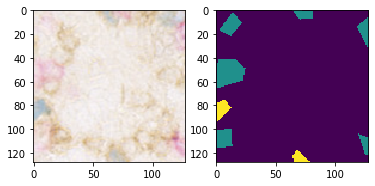

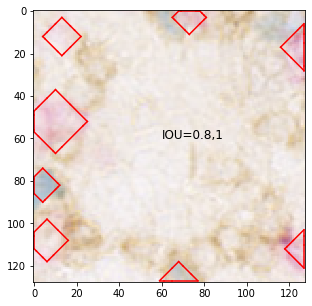

Finish plotting bbox


In [7]:
def display_new(ALL_GT_list, start_img, end_img):
    for im_num in range(start_img, end_img, 1):
        pred_sig = np.reshape(display_label[0][im_num].astype(np.float32), [-1, 128 * 128, 3])
        sign = np.reshape(pred_sig[0], (128, 128, 3))
        sign = sign.astype(np.uint8)
        plt.subplot(121),plt.imshow(sign)
        plt.subplot(122),plt.imshow(display_label[1][im_num])

        img_gray = np.reshape(rgb2gray(sign), [-1])

        ############## plot the object #############
        fig = plt.figure(figsize=[5, 5])
        #G1.plot_signal(img_gray, ax=plt.gca())
        plt.imshow(sign)
        #plt.plot(sign)
        
        ###### Code plotting the GT bbox on the graph 
        for G in ALL_GT_list[im_num-start_img]:
            bbox = G[2]

            b_coord = np.array(bbox)
            poly_coord = np.unravel_index(b_coord,(128,128))
            #print(b_coord)
            poly_coord = np.column_stack((poly_coord[1],poly_coord[0]))
            #print(poly_coord)
            hull = ConvexHull(poly_coord, qhull_options='QJ')

            for simplex in hull.simplices:
                plt.plot(poly_coord[simplex, 0], poly_coord[simplex, 1], 'r-')

        ###### Code plotting the pred bbox on the graph 
        #for P in ALL_pred_list[im_num-start_img]:
        #    bbox = P[0]

        #    b_coord = np.array(bbox)
        #    poly_coord = G1.coords[b_coord]
        #    hull = ConvexHull(poly_coord, qhull_options='QJ')

        #   for simplex in hull.simplices:
        #       plt.plot(poly_coord[simplex, 0], poly_coord[simplex, 1], 'w-')
        s = "IOU="+str(0.80)+","+str(1)
        plt.text(60.0, 60.0, s, fontsize=12)
        plt.show()
        print("Finish plotting bbox")

start_img = 0 
end_img = 1
pred_bbox = display_new(ALL_GT_list, start_img, end_img)

In [15]:
len(ALL_GT_list[1])

4

In [45]:
len(ALL_pred_list[0])

4

In [52]:
df_mAP['IOU']

0     0.488152
1       0.3025
2     0.476404
3     0.302158
4     0.456621
5     0.155963
6     0.363636
7     0.433989
8     0.138662
9     0.624309
10    0.384615
11    0.154717
12    0.451613
13    0.449857
14    0.113032
15    0.309589
16           0
17    0.510604
18    0.268409
19    0.171681
20    0.309589
21    0.271565
22    0.188764
23     0.42069
24    0.362832
25    0.320755
26     0.57971
27      0.9025
28    0.598456
29    0.463018
30      0.5025
31    0.656716
Name: IOU, dtype: object

In [56]:
with open("ALL_param_Delta_nhop_Anc_mask_iou.pkl","rb") as fp:
    ALL_param_list = pickle.load(fp)

In [58]:
len(ALL_param_list)

47